In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import random
from scipy.stats import norm, uniform, lognorm

In [2]:
dat = pd.read_csv('Howell1.csv', sep=';')

# We are interested in adult's height
dat_adults = dat[dat['age'] >= 18]

In [3]:
x_min, x_max = dat_adults['weight'].min(), dat_adults['weight'].max()

### How to determine a good prior for $\beta$

In [5]:
n_pre_prior = 100

sample_alpha = norm.rvs(size=n_pre_prior, loc=170, scale=10)
sample_beta  = norm.rvs(size=n_pre_prior, loc=0, scale=10)

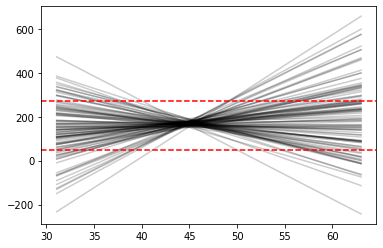

In [6]:
_ = plt.plot([x_min, x_max],
         [sample_alpha+sample_beta*(x_min-dat_adults['weight'].mean()),
          sample_alpha+sample_beta*(x_max-dat_adults['weight'].mean())], color='k', alpha=0.2)
plt.axhline(50, linestyle='--', color='red')
plt.axhline(270, linestyle='--', color='red')

#plt.savefig('regresion_mala_previa.png', transparent=True)

In [7]:
sample_alpha = norm.rvs(size=n_pre_prior, loc=170, scale=10)
sample_beta  = lognorm.rvs(size=n_pre_prior, s=1)

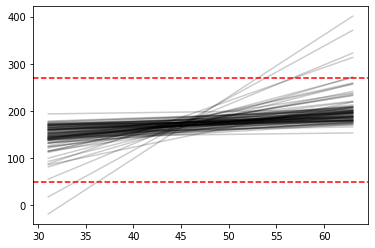

In [8]:
_ = plt.plot([x_min, x_max],
         [sample_alpha+sample_beta*(x_min-dat_adults['weight'].mean()),
          sample_alpha+sample_beta*(x_max-dat_adults['weight'].mean())], color='k', alpha=0.2)
plt.axhline(50, linestyle='--', color='red')
plt.axhline(270, linestyle='--', color='red')

#plt.savefig('regresion_buena_previa.png', transparent=True)

### Approximating the posterior

In [8]:
alpha_list = np.linspace(153.5, 155.5, 100)
beta_list  = np.linspace(0.5, 1, 100)
sigma_list = np.linspace(4, 6, 100)

alpha_grid, beta_grid, sigma_grid = np.meshgrid(alpha_list, beta_list, sigma_list)

In [9]:
like = []

for i in range(len(alpha_grid.ravel())):
    mu = alpha_grid.ravel()[i] + beta_grid.ravel()[i]*(dat_adults['weight']-dat_adults['weight'].mean())
    like.append(np.log(norm.pdf(dat_adults['height']-mu, 0, sigma_grid.ravel()[i])).sum())
    
like = np.array(like).reshape(alpha_grid.shape)

In [10]:
post_prod = like + \
np.log(norm.pdf(alpha_grid, 170, 10)) + \
np.log(uniform.pdf(sigma_grid, loc=0, scale=33)) + \
np.log(lognorm.pdf(beta_grid, s=1))

### Sampling from the posterior

In [11]:
n_sample = 10**4

candidates = pd.DataFrame(np.c_[alpha_grid.ravel(), beta_grid.ravel(), sigma_grid.ravel()], columns=['alpha', 'beta', 'sigma'])
sample_ind = random.choices(range(candidates.shape[0]), weights=np.exp(post_prod - post_prod.max()).ravel(), k=n_sample)

#candidates.iloc[sample_ind].plot.hexbin(x='mu', y='sigma', cmap='Purples', gridsize=25)

sample_posterior = candidates.iloc[sample_ind]

<AxesSubplot:xlabel='alpha', ylabel='beta'>

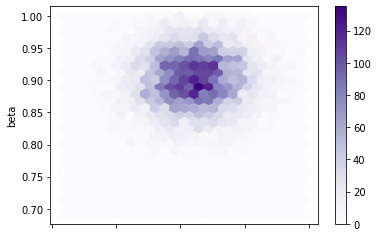

In [12]:
sample_posterior.plot.hexbin(x='alpha', y='beta', cmap='Purples', gridsize=25)

/home/dmitri/.local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='alpha', ylabel='Density'>

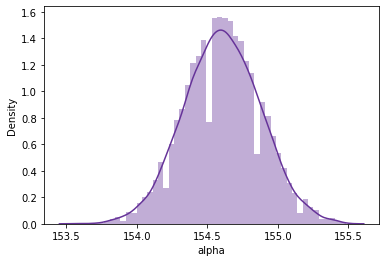

In [13]:
sns.distplot(sample_posterior['alpha'], color='rebeccapurple')

/home/dmitri/.local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='beta', ylabel='Density'>

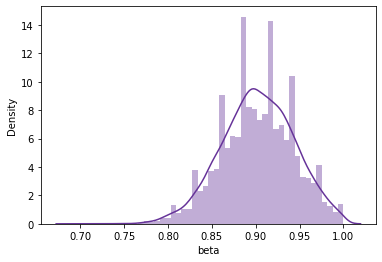

In [14]:
sns.distplot(sample_posterior['beta'], color='rebeccapurple')

/home/dmitri/.local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sigma', ylabel='Density'>

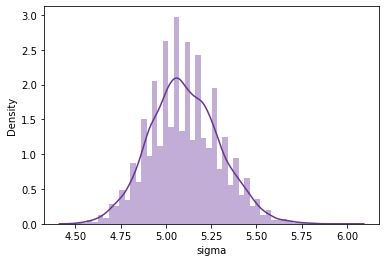

In [15]:
sns.distplot(sample_posterior['sigma'], color='rebeccapurple')

In [16]:
sample_posterior.describe()

,alpha,beta,sigma
count,10000.000000,10000.000000,10000.000000
mean,154.606186,0.902225,5.104485
std,0.271089,0.041319,0.193674
min,153.580808,0.691919,4.505051
25%,154.429293,0.873737,4.969697
50%,154.611111,0.904040,5.090909
75%,154.792929,0.929293,5.232323
max,155.479798,1.000000,6.000000


In [17]:
sample_posterior.corr().round(3)

,alpha,beta,sigma
alpha,1.000,0.021,-0.00
beta,0.021,1.000,-0.02
sigma,-0.000,-0.020,1.00


In [18]:
sample_posterior.cov().round(3)

,alpha,beta,sigma
alpha,0.073,0.000,-0.000
beta,0.000,0.002,-0.000
sigma,-0.000,-0.000,0.038


### Model considering the MAPs for $\alpha$ and $\beta$

In [19]:
alpha_map = sample_posterior['alpha'].mode()
beta_map  = sample_posterior['beta'].mode()

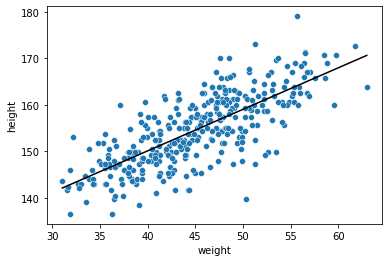

In [20]:
sns.scatterplot(data=dat_adults, x='weight', y='height')
plt.plot([x_min, x_max],
         [alpha_map+beta_map*(x_min-dat_adults['weight'].mean()),
          alpha_map+beta_map*(x_max-dat_adults['weight'].mean())], color='k')
plt.savefig('regression_adults.png', transparent=True)

### Plotting all the sample a posteriori models

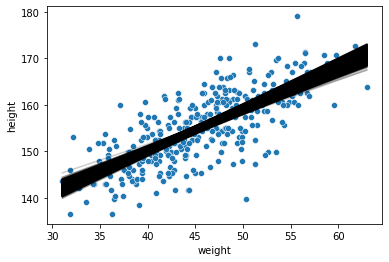

In [21]:
sns.scatterplot(data=dat_adults, x='weight', y='height')
_ = plt.plot([x_min, x_max],
         [sample_posterior['alpha']+sample_posterior['beta']*(x_min-dat_adults['weight'].mean()),
          sample_posterior['alpha']+sample_posterior['beta']*(x_max-dat_adults['weight'].mean())], color='k', alpha=0.2)

### How much is $\mu$ for a given weight

/home/dmitri/.local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

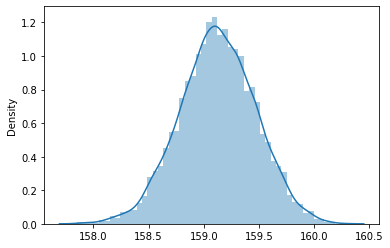

In [22]:
# weight=50
sns.distplot(sample_posterior['alpha']+sample_posterior['beta']*(50-dat_adults['weight'].mean()))

### Estimating confidence intervals

In [23]:
weight_seq = np.linspace(x_min, x_max)

In [24]:
ConfidenceIntervals = pd.DataFrame(
    np.quantile(sample_posterior['alpha']+sample_posterior['beta']*(x_min-dat_adults['weight'].mean()), [0.025, 0.975]).reshape(1,2),
    columns=['LCI', 'UCI'])

In [25]:
for i in range(1, len(weight_seq)):
    ConfidenceIntervals = pd.concat(
        [ConfidenceIntervals,
         pd.DataFrame(
             np.quantile(sample_posterior['alpha']+sample_posterior['beta']*(weight_seq[i]-dat_adults['weight'].mean()),
                         [0.025, 0.975]).reshape(1,2),
             columns=['LCI', 'UCI'])
          ])

In [26]:
ConfidenceIntervals['weight'] = weight_seq

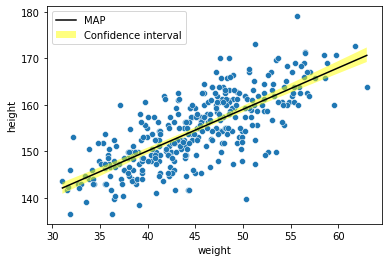

In [27]:
sns.scatterplot(data=dat_adults, x='weight', y='height')
plt.plot([x_min, x_max],
         [alpha_map+beta_map*(x_min-dat_adults['weight'].mean()),
          alpha_map+beta_map*(x_max-dat_adults['weight'].mean())], color='k', label='MAP')
plt.fill_between(ConfidenceIntervals['weight'], ConfidenceIntervals['LCI'], ConfidenceIntervals['UCI'],
                 facecolor='yellow', alpha=0.5, label='Confidence interval')
plt.legend()

### Adding prediction intervals

### Predicting height for a given weight

/home/dmitri/.local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

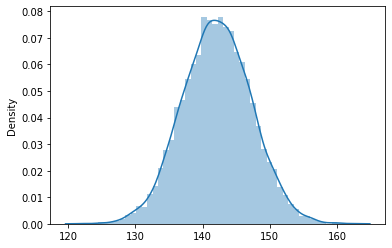

In [28]:
# weight=50
sns.distplot(
    norm.rvs(size=n_sample,
             loc=sample_posterior['alpha']+sample_posterior['beta']*(x_min-dat_adults['weight'].mean()),
             scale=sample_posterior['sigma']))

### Estimating prediction intervals

In [29]:
height_samp = norm.rvs(size=n_sample,
             loc=sample_posterior['alpha']+sample_posterior['beta']*(x_min-dat_adults['weight'].mean()),
             scale=sample_posterior['sigma'])

PredictionIntervals = pd.DataFrame(np.quantile(height_samp, [0.025, 0.975]).reshape(1,2), columns=['LPI', 'UPI'])

In [30]:
for i in range(1, len(weight_seq)):
    height_samp = norm.rvs(size=n_sample,
             loc=sample_posterior['alpha']+sample_posterior['beta']*(weight_seq[i]-dat_adults['weight'].mean()),
             scale=sample_posterior['sigma'])
    
    PredictionIntervals = pd.concat([PredictionIntervals,
                                     pd.DataFrame(np.quantile(height_samp, [0.025, 0.975]).reshape(1,2), columns=['LPI', 'UPI'])])

In [31]:
PredictionIntervals['weight'] = weight_seq

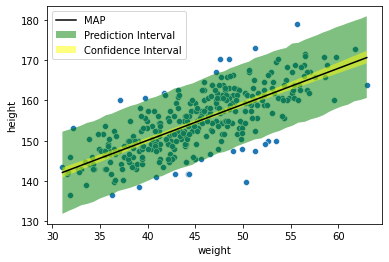

In [32]:
sns.scatterplot(data=dat_adults, x='weight', y='height')

plt.plot([x_min, x_max],
         [alpha_map+beta_map*(x_min-dat_adults['weight'].mean()),
          alpha_map+beta_map*(x_max-dat_adults['weight'].mean())], color='k', label='MAP')

plt.fill_between(PredictionIntervals['weight'], PredictionIntervals['LPI'], PredictionIntervals['UPI'],
                 facecolor='green', alpha=0.5, label='Prediction Interval')

plt.fill_between(ConfidenceIntervals['weight'], ConfidenceIntervals['LCI'], ConfidenceIntervals['UCI'],
                 facecolor='yellow', alpha=0.5, label='Confidence Interval')
plt.legend()